In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pylab as plt

In [8]:
test = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Datos Pesados/210301_feng_Test_TP2_Datos_2020-2C.csv')
train = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Datos Pesados/210301_feng_Train_TP2_Datos_2020-2C.csv')


test = test.drop(columns ="Unnamed: 0")
train = train.drop(columns ="Unnamed: 0")

In [9]:
tscv = TimeSeriesSplit(n_splits=5)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(train.drop(columns = 'Stage'), train['Stage'], test_size=0.2)


In [11]:
xg_reg = xgb.XGBRegressor(
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 25, n_estimators = 100)


xg_reg.fit(X_train,y_train)



preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

xg_reg.score(X_test,y_test)

RMSE: 0.336472


0.5468159738812352

In [6]:
xg_reg = xgb.XGBRegressor(max_depth = 5,min_child_weight = 1,gamma = 0,subsample = 0.8
                          , colsample_bytree = 0.8,scale_pos_weight = 1 )


xg_reg.fit(X_train,y_train)



preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
xg_reg.score(X_test,y_test)

RMSE: 0.327910


0.5693024482871605

In [7]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["Stage"].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)#, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Stage'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Stage'].values, dtrain_predictions))
    print( "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Stage'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)
    feat_imp.drop('Opportunity_ID').head(10).plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [16]:
predictors = [x for x in train.columns if x not in ["Stage"]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


Model Report
Accuracy : 0.9679
AUC Score (Train): 0.995247


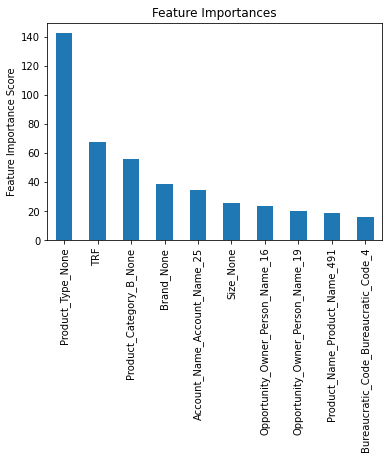

In [9]:
modelfit(xgb1, train, predictors)

# Tune max_depth and min_child_weight

In [10]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch1.fit(train[predictors],train["Stage"])

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([28.27448401, 30.74937596, 31.69891105, 45.49398417, 45.26857963,
         47.0631865 , 63.13810883, 64.64093561, 63.33855066, 80.14882269,
         79.47482791, 64.86369042]),
  'std_fit_time': array([11.64518465, 12.07749666, 11.67819096, 15.36393446, 16.84882205,
         18.52892491, 23.50540986, 22.50279897, 23.1685656 , 29.14597641,
         31.16846409, 15.49092465]),
  'mean_score_time': array([0.49546251, 0.54378543, 0.47485938, 0.5444993 , 0.4249351 ,
         0.58110027, 0.4727921 , 0.48723679, 0.47462783, 0.47030253,
         0.42838244, 0.4140624 ]),
  'std_score_time': array([0.10802081, 0.12210822, 0.15865275, 0.19847616, 0.16396382,
         0.12169405, 0.01898817, 0.06809642, 0.12525112, 0.14240303,
         0.09427904, 0.19401931]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         f

In [11]:

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([28.27448401, 30.74937596, 31.69891105, 45.49398417, 45.26857963,
         47.0631865 , 63.13810883, 64.64093561, 63.33855066, 80.14882269,
         79.47482791, 64.86369042]),
  'std_fit_time': array([11.64518465, 12.07749666, 11.67819096, 15.36393446, 16.84882205,
         18.52892491, 23.50540986, 22.50279897, 23.1685656 , 29.14597641,
         31.16846409, 15.49092465]),
  'mean_score_time': array([0.49546251, 0.54378543, 0.47485938, 0.5444993 , 0.4249351 ,
         0.58110027, 0.4727921 , 0.48723679, 0.47462783, 0.47030253,
         0.42838244, 0.4140624 ]),
  'std_score_time': array([0.10802081, 0.12210822, 0.15865275, 0.19847616, 0.16396382,
         0.12169405, 0.01898817, 0.06809642, 0.12525112, 0.14240303,
         0.09427904, 0.19401931]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         f

In [12]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch2.fit(train[predictors],train["Stage"])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([36.66192212, 36.63182402, 37.62777352, 45.61533866, 44.20999956,
         46.19148359, 54.54270864, 56.53576055, 45.51052098]),
  'std_fit_time': array([13.20617446, 13.08952425, 13.49171883, 16.82020149, 15.60187278,
         17.25477263, 19.65920162, 22.37556842, 11.05921984]),
  'mean_score_time': array([0.51677155, 0.46362433, 0.35691628, 0.43649592, 0.39372582,
         0.53315291, 0.36571188, 0.50752749, 0.31344075]),
  'std_score_time': array([0.1244929 , 0.06693269, 0.05817741, 0.11731922, 0.07361233,
         0.07710168, 0.06347236, 0.14128007, 0.10877313]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                    

In [13]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch2b.fit(train[predictors],train["Stage"])

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
  

In [14]:
#modelfit(gsearch3.best_estimator_, train, predictors)
#gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_


Model Report
Accuracy : 0.8605
AUC Score (Train): 0.940392


({'mean_fit_time': array([36.37954926, 37.32703686, 37.35704727, 31.05579853]),
  'std_fit_time': array([14.05210404, 12.8600868 , 14.34348466,  8.46051539]),
  'mean_score_time': array([0.50670877, 0.47912006, 0.47222619, 0.35850625]),
  'std_score_time': array([0.09264974, 0.09624598, 0.15680727, 0.20294056]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.91504065, 0.91845936, 0.91655882, 0.91277735]),
  'split1_test_score': array([0.85802971, 0.85732023, 0.85695867, 0.85980568]),
  'split2_test_score': array([0.81535439, 0.8163594 , 0.80823329, 0.80938495]),
  'split3_test_score': array([0.88622744, 0.8757028 , 0.86661986, 0.86100953]),
  'split4_test_score': array([0.91709649, 0.91649624, 0.91498432, 0.9174003

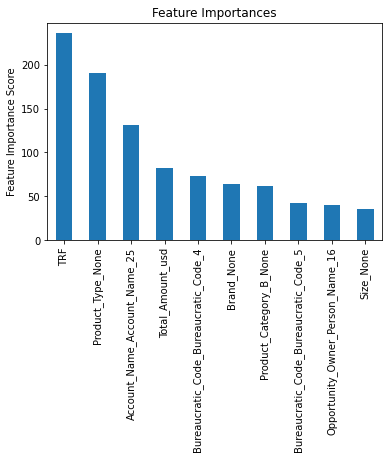

In [15]:
modelfit(gsearch2b.best_estimator_, train, predictors)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [16]:
param_test1b = {
 'max_depth':range(10,60,10)},
 #'min_child_weight':range(1,6,2)}
gsearch1b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1b, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch1b.fit(train[predictors],train["Stage"])

gsearch1b.cv_results_, gsearch1b.best_params_, gsearch1b.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([ 88.61485472, 182.08445868, 186.46194034, 203.66431637,
         166.05609145]),
  'std_fit_time': array([ 35.28592908,  87.54133118,  93.22059248, 127.40217491,
          62.32782631]),
  'mean_score_time': array([0.63790364, 0.635706  , 0.58546958, 0.68867831, 0.48859353]),
  'std_score_time': array([0.13837779, 0.19529772, 0.163397  , 0.22853787, 0.22020501]),
  'param_max_depth': masked_array(data=[10, 20, 30, 40, 50],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 10},
   {'max_depth': 20},
   {'max_depth': 30},
   {'max_depth': 40},
   {'max_depth': 50}],
  'split0_test_score': array([0.91899181, 0.92022716, 0.91643966, 0.91643966, 0.91643966]),
  'split1_test_score': array([0.86336521, 0.8705161 , 0.86614401, 0.86614401, 0.86614401]),
  'split2_test_score': array([0.82335151, 0.82313654, 0.82714124, 0.82509129, 0.82509129]),
  'split3_test_score': array([0.9007401

In [17]:
#Con max_depth 5  saco mejor score 1

# Tune gamma

In [18]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch3.fit(train[predictors],train["Stage"])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([40.19658732, 36.45095515, 35.2805099 , 35.67011986, 29.28953171]),
  'std_fit_time': array([14.28330608, 12.53480724, 12.99790425, 12.49770563,  6.14788938]),
  'mean_score_time': array([0.44440775, 0.3231616 , 0.48876896, 0.4307281 , 0.3407351 ]),
  'std_score_time': array([0.06852243, 0.07169851, 0.07663676, 0.13440441, 0.15102199]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.91504065, 0.91616287, 0.91386714, 0.9173937 , 0.91645097]),
  'split1_test_score': array([0.85802971, 0.85731265, 0.8572793 , 0.85676993, 0.85890822]),
  'split2_test_score': array([0.81535439, 0.81207062, 0.81054659, 0.81384725, 0.8122595 ]),
  'split3_test_score': array([0.88622744, 0.87907156, 0.88496331, 0.88738096, 0.8


Model Report
Accuracy : 0.9308
AUC Score (Train): 0.982798


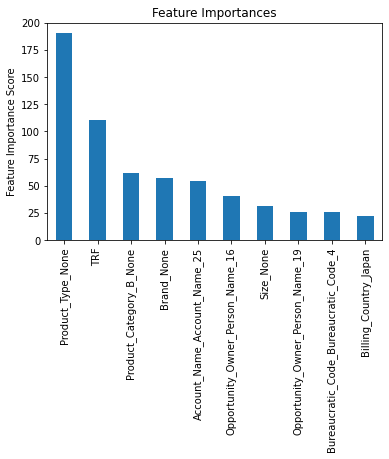

In [19]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [20]:
#ganma = 0.4

# Tune subsample and colsample_bytree

In [21]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch4.fit(train[predictors],train["Stage"])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([39.06704831, 40.47664909, 37.33181124, 37.35402732, 41.73030615,
         43.02143416, 41.89089308, 40.31709199, 46.50602918, 47.8750617 ,
         46.87921023, 44.34613514, 50.91870213, 54.43665581, 50.54625535,
         39.24295759]),
  'std_fit_time': array([16.44134706, 13.28809782, 12.89869349, 13.3397398 , 15.63115078,
         16.0898288 , 14.49061748, 14.1752635 , 19.57698885, 19.12429594,
         16.64463459, 15.5489488 , 21.64298384, 20.76723198, 16.71452709,
          9.32669925]),
  'mean_score_time': array([0.45285659, 0.51770072, 0.37450752, 0.38183212, 0.47068892,
         0.45446692, 0.4405961 , 0.506463  , 0.40225415, 0.37689691,
         0.45764189, 0.46092634, 0.48713417, 0.52211995, 0.47534533,
         0.34636536]),
  'std_score_time': array([0.14652024, 0.10491384, 0.15381928, 0.11617191, 0.08427292,
         0.09836035, 0.07147499, 0.11138689, 0.04930216, 0.1015548 ,
         0.09484743, 0.09557729, 0.07467014, 0.11242901, 0.12759027,
 

In [22]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch5.fit(train[predictors],train["Stage"])

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
  

In [23]:
#{'colsample_bytree':0.6 , 'subsample': 0.9}, es la mejor score

# Tuning Regularization Parameters

In [24]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch6.fit(train[predictors],train["Stage"])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([47.83879423, 49.13199172, 48.64896622, 47.40429769, 23.36447005]),
  'std_fit_time': array([18.06708481, 18.28064437, 18.4078704 , 16.41193909,  6.5637628 ]),
  'mean_score_time': array([0.48166022, 0.46223626, 0.44895945, 0.46177688, 0.32945662]),
  'std_score_time': array([0.0769056 , 0.0783875 , 0.1545695 , 0.10652086, 0.13353589]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.91431664, 0.91463565, 0.91727303, 0.91518922, 0.83195092]),
  'split1_test_score': array([0.85735661, 0.85837384, 0.85122977, 0.85247363, 0.84316853]),
  'split2_test_score': array([0.81763775, 0.81612907, 0.81594557, 0.81804236, 0.7726186 ]),
  'split3_test_score': array([0.88276914, 0.88445013, 0

In [25]:
param_test6b = {
 'reg_alpha':[110, 120, 130,140,150]
}
gsearch6b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6b, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch6b.fit(train[predictors],train["Stage"])
gsearch6b.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([24.03193617, 26.33531585, 26.05536604, 26.43182125, 19.33587742]),
  'std_fit_time': array([10.16341938, 11.01980479,  9.96782877, 11.64220999,  4.02935443]),
  'mean_score_time': array([0.46505308, 0.56486592, 0.48111572, 0.50863848, 0.30868816]),
  'std_score_time': array([0.08462308, 0.12317719, 0.17169343, 0.16722228, 0.11109537]),
  'param_reg_alpha': masked_array(data=[110, 120, 130, 140, 150],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 110},
   {'reg_alpha': 120},
   {'reg_alpha': 130},
   {'reg_alpha': 140},
   {'reg_alpha': 150}],
  'split0_test_score': array([0.82620858, 0.82190974, 0.82001373, 0.81778135, 0.81885907]),
  'split1_test_score': array([0.8421081 , 0.8387032 , 0.83777314, 0.83926184, 0.8386039 ]),
  'split2_test_score': array([0.77115138, 0.76974329, 0.76856015, 0.77152068, 0.77098247]),
  'split3_test_score': array([0.84212732, 0.83754861, 0.8

In [26]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=tscv)
gsearch7.fit(train[predictors],train["Stage"])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([48.94547248, 52.49589252, 54.95985198, 55.51537299, 43.91463985]),
  'std_fit_time': array([17.4879204 , 19.92503158, 22.13211685, 19.93982736,  9.99473751]),
  'mean_score_time': array([0.46853151, 0.60142412, 0.40286064, 0.67131662, 0.37264361]),
  'std_score_time': array([0.12754089, 0.19901397, 0.1225774 , 0.21882504, 0.18678342]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'split0_test_score': array([0.91431664, 0.91431362, 0.91397876, 0.91463565, 0.91687331]),
  'split1_test_score': array([0.85735661, 0.85992165, 0.85881499, 0.85837384, 0.85271391]),
  'split2_test_score': array([0.81763775, 0.81763775, 0.81769226, 0.81612907, 0.81784197]),
  'split3_test_score': array([0.88276914, 0.88276


Model Report
Accuracy : 0.9175
AUC Score (Train): 0.976971


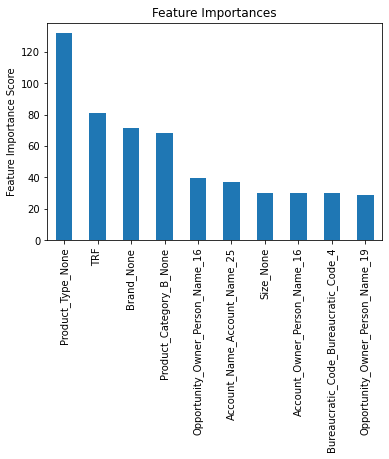

In [27]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

In [28]:
#Con reg_alpha =  mando el mejor score

# Reducing Learning Rate


Model Report
Accuracy : 0.8118
AUC Score (Train): 0.884064


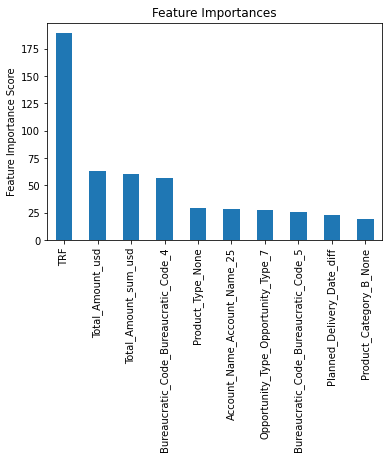

In [29]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=5,
 gamma=0.3,
 subsample=0.7,
 colsample_bytree=0.7,
 reg_alpha=100,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

In [17]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb4.fit(train[predictors], train['Stage'],eval_metric='auc')

prediccion = xgb4.predict_proba(test)
prediccion

array([[0.21578312, 0.7842169 ],
       [0.42971444, 0.57028556],
       [0.09429532, 0.9057047 ],
       ...,
       [0.5668784 , 0.43312162],
       [0.32585204, 0.67414796],
       [0.62194544, 0.37805456]], dtype=float32)

In [19]:
output = pd.DataFrame({'Opportunity_ID':test.Opportunity_ID, 'Target': prediccion[:,1]}) 
output

,Opportunity_ID,Target
0,10689,0.784217
1,10690,0.570286
2,10691,0.905705
3,10692,0.498693
4,10693,0.983425
...,...,...
1562,12364,0.972970
1563,12365,0.532908
1564,12366,0.433122
1565,12367,0.674148


In [20]:
final=output.groupby('Opportunity_ID').max()
final

,Target
Opportunity_ID,
10689,0.784217
10690,0.570286
10691,0.905705
10692,0.498693
10693,0.983425
...,...
12364,0.972970
12365,0.532908
12366,0.433122


In [21]:
final.to_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Resultados/XGBoostScoreTimeSeriesSplit.csv')